In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
import pandas as pd
import math
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker
from matplotlib import rc

def custom_grouping(index):
    return index // 1000

names_bw=['time', 'bw', 'op1', 'size', 'op2' ]
names_latency=['time', 'latency', 'op2', 'write_size', 'op3']

In [2]:
# Define a custom grouping function
  
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/home/surbhi/measurements/worst_case/STL/4K/90-10-LBA/90Util/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])


In [3]:
# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())
print("End time: " + str(int(end_time)))

# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = 4096
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)
last_non_zero_index = data_written_ms[data_written_ms.ne(0).any(axis=1)].index[-1]
data_written_ms = data_written_ms.loc[:last_non_zero_index]

End time: 114826927


/tmp/ipykernel_227818/3725175188.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[446.56957485 446.56957485 446.56957485 446.56957485 446.56957485
 446.56957485 446.56957485 446.56957485 446.56957485]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms.loc[start:end-1] += write_rate_per_ms


1310719


In [4]:
#assert math.ceil(data_written_ms.data_written_bytes.sum()) == len(df)*4096
print(math.ceil(data_written_ms.data_written_bytes.sum()))
print(len(df) * 4096)

5368709121
5368709120


In [5]:
chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
print(df_grouped.describe())
print(df_grouped.info())

               index  data_written_bytes  cumulative_gb
count  114827.000000       114827.000000  114827.000000
mean    57413.000000            0.044589       3.962948
std     33147.844017            0.509212       0.842747
min         0.000000            0.000000       0.006386
25%     28706.500000            0.004815       3.216151
50%     57413.000000            0.007402       3.993062
75%     86119.500000            0.009973       4.871017
max    114826.000000           14.662164       5.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114827 entries, 0 to 114826
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               114827 non-null  int64  
 1   data_written_bytes  114827 non-null  float64
 2   cumulative_gb       114827 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 2.6 MB
None


Average1: 0
Average2: 11
Cumulative GB where all subsequent 'data_written_bytes' are < 2: 2.43923978177921


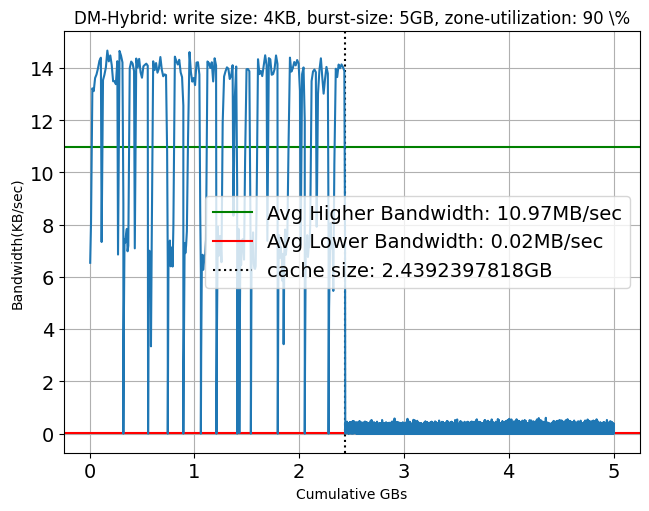

In [6]:
data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'
fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

# Plot vertical lines at x where y is higher than the threshold
# Iterate through the DataFrame in reverse order
for i in range(len(df_grouped)):
    # Check if all subsequent 'data_written_bytes' are less than 10
    if (df_grouped['data_written_bytes'].iloc[i:] < 2).all():
        cumulative_gb_value = df_grouped['cumulative_gb'].iloc[i]
        print(f"Cumulative GB where all subsequent 'data_written_bytes' are < 2: {cumulative_gb_value}")
        break
else:
    print("No such point found where all subsequent 'data_written_bytes' are < 2.")


# If you want the first occurrence where 'data_written_bytes' is less than 75
# Plot vertical lines at x where y is higher than the threshold
plt.axvline(x=cumulative_gb_value, color='black', linestyle=':', label="cache size: " + str(round(cumulative_gb_value, 10)) + "GB")

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Bandwidth(KB/sec)')
plt.grid(True)  # Optionally, add grid lines
plt.title("DM-Hybrid: write size: 4KB, burst-size: 5GB, zone-utilization: 90 \%")
    
plt.savefig('/home/surbhi/github/surbhi-plots/new/STL/4K_90Util_STL_CGBW.png', bbox_inches='tight')
plt.show()

The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.0
Highest x is 114826$10^{5}$


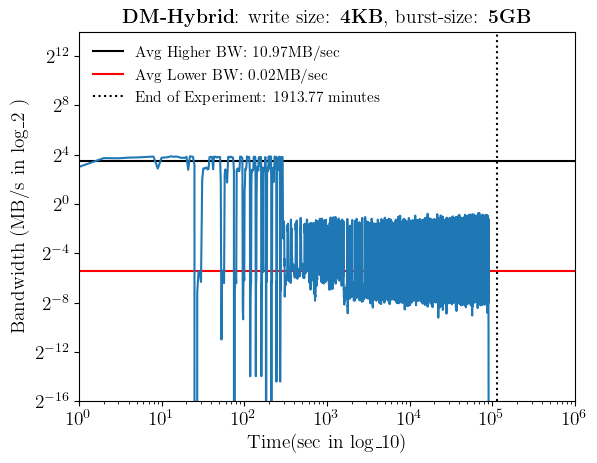

In [7]:
import matplotlib.ticker as ticker
# Custom function to format y-axis ticks
def format_tick(value, tick_number):
    if value == 20000:
        return '20K'
    if value == 40000:
        return '40K'
    if value == 60000:
        return '60K'
    if value == 80000:
        return '80K'
    if value == 100000:
        return '100K'
    if value == 120000:
        return '120K'
    if value == 140000:
        return '140K'
    if value == 160000:
        return '160K'
    if value == 180000:
        return '180K'
    return int(value)
rc('text', usetex=True)  # Enable LaTeX text rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots
common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**5)
plt.xticks(common_ticks)

xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper left', fontsize=11, frameon=False)

print("Highest x is " + str(xmax) + log10_format(xmax, 0))
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r'$\textbf{DM-Hybrid}$: write size: $\textbf{4KB}$, burst-size: $\textbf{5GB}$', fontsize=14, fontweight='bold')   
#plt.xlabel(r'$\textbf{Normal}$ text and $\textbf{Bold text}$')   
#plt.savefig('/home/surbhi/github/surbhi-plots/new/STL/4K_90Util_STL_BW.pdf', bbox_inches='tight', format="pdf")
plt.savefig('/home/surbhi/Downloads/4K_90Util_STL_BW.pdf', bbox_inches='tight', format="pdf")
plt.savefig('/home/surbhi/Downloads/4K_90Util_STL_BW.pdf', bbox_inches='tight', format="pdf")
plt.show()


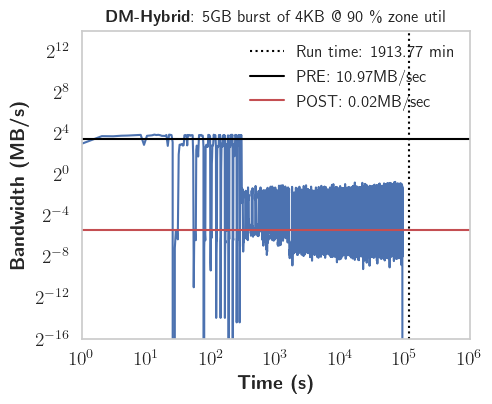

In [13]:
#now plot the data with seaborn
#remove the grid and use white background
sns.set_theme(style="whitegrid")
plt.figure(figsize=(5, 4))
plt.grid(False)
ax = sns.lineplot(x='index', y='data_written_bytes', data=df_grouped)
plt.title(r"$\textbf{DM-Hybrid}$: 5GB burst of 4KB @ 90 \% zone util")

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks, [str(2**i) for i in range(-16, 14, 2)])
# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

lowest_power_of_2 = 2 ** -16
ax.set_ylim(lowest_power_of_2 , 2**14)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
#set x-axis to log scale
ax.set_xscale('log')
#set y-axis to log base 2 scale
ax.set_yscale('log', base=2)
plt.ylabel(r'$\textbf{Bandwidth (MB/s)}$', fontsize=14)

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**5)
plt.xticks(common_ticks,fontsize=14)
xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='Run time: ' + str(xmin) + ' min')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\textbf{Time (s)}$', fontsize=14)

plt.axhline(y=average_mode2, color='black', linestyle='-', label='PRE: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='POST: ' + avg_bw_str1)
plt.legend(loc='upper right', fontsize=12, frameon=False)
  
plt.savefig('/home/surbhi/Downloads/4K_90Util_STL_BW.pdf', bbox_inches='tight', format="pdf")


139129281.0
57279.023449536


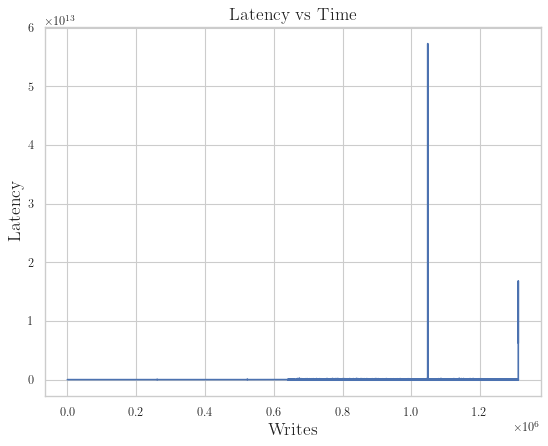

In [14]:
dur_cols = ['duration']
df = pd.read_csv('/home/surbhi/measurements/worst_case/STL/4K/90-10-LBA/90Util/lat_log_avg_lat.1.log', names=names_latency, usecols=dur_cols)
#df['duration'] = df['duration']/1e9 #convert ns to seconds

# Plot the data
# Create the line plot
plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.grid(True)  # Optionally, add grid lines
plt.plot(df.index, df['duration'])

# Add labels and title
plt.xlabel('Writes', fontsize=16)

plt.ylabel('Latency', fontsize=16)
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Latency vs Time', fontsize=16)
#df.describe()
print(str(df['duration'].median()))
print(str(df['duration'].max()/1e9))

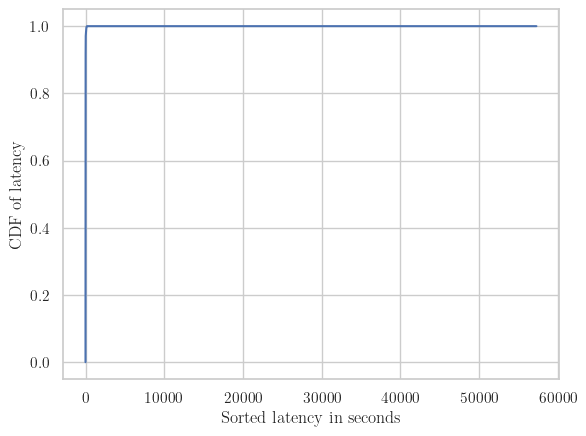

In [15]:
# compute the CDF
cdfx = np.sort(df['duration']/1e9)
cdfy = np.linspace(1 / len(cdfx), 1.0, len(cdfx))
# plot the CDF
plt.xlabel("Sorted latency in seconds")
plt.ylabel("CDF of latency")
plt.plot(cdfx, cdfy)
plt.show()


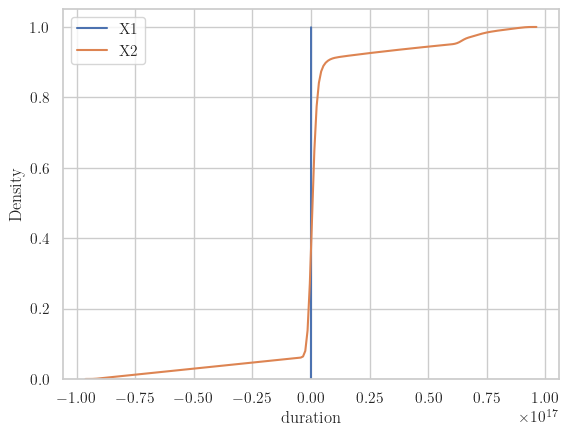

In [16]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

X1 = df['duration']
#PDF is a probability that a random variable, say X, will take a value exactly equal to x.
X2 = (X1 ** 2) / 100
sns.kdeplot(data = X1, cumulative = True, label = "X1")
sns.kdeplot(data = X2, cumulative = True, label = "X2")
plt.legend()
plt.show()

/tmp/ipykernel_227818/2164621549.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


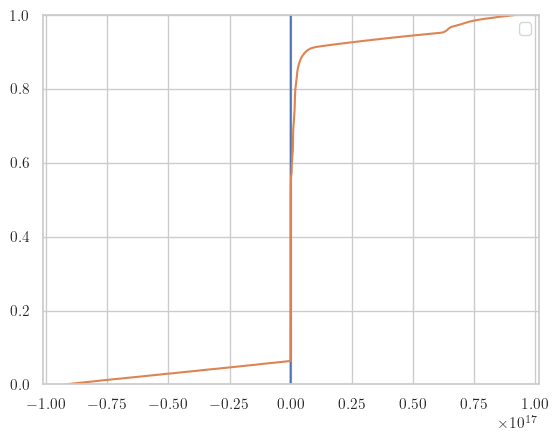

In [17]:
def cdf(x, plot=True, *args, **kwargs):
    x, y = sorted(x), np.arange(len(x)) / len(x)
    return plt.plot(x, y, *args, **kwargs) if plot else (x, y)

X1 = df['duration']
X2 = (X1 ** 2) / 100
#cdf(X1)
#cdf(X2)
plt.ecdf(X1)
plt.ecdf(X2)
plt.legend()